In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import os
import pandas as pd
from SH_rand import SH_random_serial_ensemble

In [2]:
def Load_NC_Data(profile):
    subdirs = {'fx1_fy0': '2023-03-03/215623',
                'fx1_fy1': '2023-03-06/173337',
                'fx2_fy0': '2023-03-07/182727',
                'fx2_fy1': '2023-03-08/165852',
                'fx2_fy2': '2023-03-09/163013'}
            
    data_path = f'/data/nriemer/d/sf20/les_output/{subdirs[profile]}'
    ncdata = Dataset(os.path.join(data_path, 'wrfout_modified'))
    tracer_data = ncdata['so2']
    return tracer_data

def Get_Tracer(tracer_data, time_idx):
    return tracer_data[time_idx]

In [3]:
profiles = ['fx1_fy0', 'fx1_fy1', 'fx2_fy0', 'fx2_fy1', 'fx2_fy2']

In [4]:
# load permutation array
d1, d2 = 100, 100
permutation_array = np.load(f'{d1}x{d2}_permutation_array.npy').astype(int)

In [5]:
# The following are the python functions for obtaining the spatial heterogeneity
# metrics. Discrete Hk norms(Enter numpy array f, real value k, and grid dimension L)

def HkNorm(f, k, L):
    """Compute the discrete Hk norm for the passed array

    Arguments
        f: numpy array
        k: real value
        L: grid dimension
    
    Returns:
        N: norm value
    """ 
    N=0
    F = np.fft.fft2(f)
    F = np.absolute(F)
    for i , x1 in enumerate(F): 
        for j , x in enumerate(x1):
            N += np.power(1.+(i*i+j*j)*L*L, k)*(x*x) 
    N = np.sqrt(N)
    return N

In [6]:
def Compute_Tracer_SH(SH_data, tracer_data, z_level_iterable, time_idx, norm='SH', SH_std_err_data=None, k=None):
    print(f'Time index: {time_idx}')
    
    t_tracer_data = Get_Tracer(tracer_data, time_idx)
    if norm == f'H{k}Norm':
        t_spatial_het = [HkNorm(t_tracer_data[z, :, :], k=k, L=1) for z in z_level_iterable]
        SH_data.iloc[time_idx, :] = t_spatial_het
        return SH_data
    if norm == 'SH':         
        n_permutations = 100
        n_estimates = 20
        t_spatial_het = []
        t_std_err = []
        for z in z_level_iterable:
            SH_estimate, SH_estimates = SH_random_serial_ensemble(n_estimates, t_tracer_data[z, :, :], n_permutations, permutation_array)
            t_spatial_het.append(SH_estimate)
            std_err = SH_estimates.std() / np.sqrt(n_estimates)
            t_std_err.append(std_err)
            
        SH_std_err_data.iloc[time_idx, :] = t_std_err
        SH_data.iloc[time_idx, :] = t_spatial_het
        return SH_data, SH_std_err_data
    

In [7]:
def Create_SH_Data(tracer_data, t_interval, z_level_iterable):
    n_tvals = tracer_data.shape[0]
    SH_data = pd.DataFrame(columns=[f'z_{i}' for i in z_level_iterable], index=np.arange(0, n_tvals*t_interval, t_interval))
    SH_data.index.name = 'time_m'
    return SH_data

In [8]:
def SH_data_wrapper(PROFILE, tracer_data, t_interval, z_level_iterable, time_iterable, SH_norm='SH', k=None):
    if k==None and SH_norm == 'HkNorm':
        raise ValueError('Variable "k" cannot be Nonetype if metric is HkNorm')
    if SH_norm == 'HkNorm':
        SH_norm = f'H{k}Norm'

    if not os.path.exists(f'{SH_norm}_data_{PROFILE}.csv'):
        SH_data = Create_SH_Data(tracer_data, t_interval, z_level_iterable)
        print(f'Writing {SH_norm}_data_{PROFILE}.csv to file')
        SH_data.to_csv(f'{SH_norm}_data_{PROFILE}.csv')
        if SH_norm=='SH':
            SH_std_err_data = SH_data.copy()
            print(f'Writing SH_std_err_data_data_{PROFILE}.csv to file')
            SH_std_err_data.to_csv(f'SH_std_err_data_data_{PROFILE}.csv')
    else:
        print(f'Reading {SH_norm}_data_{PROFILE}.csv')
        SH_data = pd.read_csv(f'{SH_norm}_data_{PROFILE}.csv', index_col='time_m')

        # if SH data exists for one of the specified time intervals, keep 
        # existing values by removing interval from times for which SH will be 
        # computed.
        remove_t_idxs = []
        for time_idx in time_iterable:
            if SH_data.iloc[time_idx].isnull().any() == False:
                print(f'SH data for time index {time_idx} already exists, skipping computation')
                remove_t_idxs.append(time_idx)
        for time_idx in remove_t_idxs:
            if isinstance(time_iterable, list):
                time_iterable.remove(time_idx)
            else:
                time_iterable = np.delete(time_iterable, np.where(time_iterable==time_idx))
            
        if SH_norm=='SH':
            print(f'Reading SH_std_err_data_data_{PROFILE}.csv')
            SH_std_err_data = pd.read_csv(f'SH_std_err_data_data_{PROFILE}.csv', index_col='time_m')
    
    for time_idx in time_iterable:
        if SH_norm == 'SH':
            SH_data, SH_std_err_data = Compute_Tracer_SH(SH_data, tracer_data, z_level_iterable,
                                                         time_idx, norm=SH_norm, SH_std_err_data=SH_std_err_data)
        if SH_norm == f'H{k}Norm':
            SH_data = Compute_Tracer_SH(SH_data, tracer_data, z_level_iterable, time_idx, norm=SH_norm, k=k)
    
    print(f'Writing {SH_norm}_data_{PROFILE}.csv to file')
    SH_data.to_csv(f'{SH_norm}_data_{PROFILE}.csv')
    if SH_norm=='SH':
        print(f'Writing SH_std_err_data_data_{PROFILE}.csv to file')
        SH_std_err_data.to_csv(f'SH_std_err_data_data_{PROFILE}.csv')
        return SH_data, SH_std_err_data
    return SH_data

In [53]:
time_iterable = [3, 12, 72]
for PROFILE in profiles:
    tracer_data = Load_NC_Data(profile=PROFILE)
    n_zlevels = tracer_data.shape[1]
    n_tvals = tracer_data.shape[0]
    t_interval = 5

    #time_iterable = range(n_tvals) # compute SH for each time step
    SH_data, SH_std_err_data = SH_data_wrapper(PROFILE, tracer_data, t_interval, 
                              z_level_iterable=np.arange(0, n_zlevels, 10), time_iterable=time_iterable, SH_norm='SH')

Writing SH_data_fx1_fy0.csv to file
Writing SH_std_err_data_data_fx1_fy0.csv to file
Time index: 3
Time index: 12
Time index: 72
Writing SH_data_fx1_fy0.csv to file
Writing SH_std_err_data_data_fx1_fy0.csv to file


In [97]:
time_iterable = [3, 12, 72]
for PROFILE in profiles:
    tracer_data = Load_NC_Data(profile=PROFILE)
    n_zlevels = tracer_data.shape[1]
    n_tvals = tracer_data.shape[0]
    t_interval = 5

    #time_iterable = range(n_tvals) # compute SH for each time step
    SH_data = SH_data_wrapper(PROFILE, tracer_data, t_interval, 
                              z_level_iterable=np.arange(0, n_zlevels, 10), time_iterable=time_iterable, SH_norm='HkNorm', k=-1)

Writing HkNorm_data_fx1_fy0.csv to file
Time index: 3
Time index: 12
Time index: 72
Writing HkNorm_data_fx1_fy0.csv to file
Writing HkNorm_data_fx1_fy1.csv to file
Time index: 3
Time index: 12
Time index: 72
Writing HkNorm_data_fx1_fy1.csv to file
Writing HkNorm_data_fx2_fy0.csv to file
Time index: 3
Time index: 12
Time index: 72
Writing HkNorm_data_fx2_fy0.csv to file
Writing HkNorm_data_fx2_fy1.csv to file
Time index: 3
Time index: 12
Time index: 72
Writing HkNorm_data_fx2_fy1.csv to file
Writing HkNorm_data_fx2_fy2.csv to file
Time index: 3
Time index: 12
Time index: 72
Writing HkNorm_data_fx2_fy2.csv to file


In [9]:
time_iterable = [3, 12, 72]
for PROFILE in profiles:
    tracer_data = Load_NC_Data(profile=PROFILE)
    n_zlevels = tracer_data.shape[1]
    n_tvals = tracer_data.shape[0]
    t_interval = 5

    #time_iterable = range(n_tvals) # compute SH for each time step
    SH_data = SH_data_wrapper(PROFILE, tracer_data, t_interval, 
                              z_level_iterable=np.arange(0, n_zlevels, 10), time_iterable=time_iterable, SH_norm='HkNorm', k=-2)

Writing H-2Norm_data_fx1_fy0.csv to file
Time index: 3
Time index: 12
Time index: 72
Writing H-2Norm_data_fx1_fy0.csv to file
Writing H-2Norm_data_fx1_fy1.csv to file
Time index: 3
Time index: 12
Time index: 72
Writing H-2Norm_data_fx1_fy1.csv to file
Writing H-2Norm_data_fx2_fy0.csv to file
Time index: 3
Time index: 12
Time index: 72
Writing H-2Norm_data_fx2_fy0.csv to file
Writing H-2Norm_data_fx2_fy1.csv to file
Time index: 3
Time index: 12
Time index: 72
Writing H-2Norm_data_fx2_fy1.csv to file
Writing H-2Norm_data_fx2_fy2.csv to file
Time index: 3
Time index: 12
Time index: 72
Writing H-2Norm_data_fx2_fy2.csv to file


In [10]:
def Load_SH_Data():
    sh_dict = {'fx1_fy0': '',
            'fx1_fy1': '',
            'fx2_fy0': '',
            'fx2_fy1': '',
            'fx2_fy2': ''}

    sh_std_err_dict = {'fx1_fy0': '',
                        'fx1_fy1': '',
                        'fx2_fy0': '',
                        'fx2_fy1': '',
                        'fx2_fy2': ''}

    for profile in sh_dict.keys():
        sh_df = pd.read_csv(f'SH_data_{profile}.csv', index_col='time_m')
        sh_dict[profile] = sh_df

        sh_std_err_df = pd.read_csv(f'SH_std_err_data_data_{profile}.csv', index_col='time_m')
        sh_std_err_dict[profile] = sh_std_err_df
    return sh_dict, sh_std_err_dict

def Load_Hk_Data(k):
    hk_dict = {'fx1_fy0': '',
                'fx1_fy1': '',
                'fx2_fy0': '',
                'fx2_fy1': '',
                'fx2_fy2': ''}

    for profile in hk_dict.keys():
        sh_df = pd.read_csv(f'H{k}Norm_data_{profile}.csv', index_col='time_m')
        hk_dict[profile] = sh_df

    return hk_dict

In [101]:

sh_dict, sh_std_err_dict = Load_SH_Data()

In [ ]:
hk_dict = Load_Hk_Data(k=-1)

In [11]:
hk_dict = Load_Hk_Data(k=-2)

In [ ]:
z_levels = np.arange(0, 199, 1)

for profile in sh_dict.keys():
    sh_df = sh_dict[profile]
    fig, ax = plt.subplots(1, 1, figsize=(7, 4.5))

    fx, fy = tuple(i.replace('fx', '').replace('fy', '') for i in profile.split('_'))

    for t in [1, 2, 3, 12]:
        tstamp = str(t*5)
        ax.plot(z_levels, sh_df.iloc[t, :].values, label=f't = {tstamp} m')
        ax.set_yscale('log')

        ax.set_ylim(1e-2, 1e6)
    ax.set_ylabel('Spatial Heterogeneity (arbitrary units)', fontsize=12)
    ax.set_xlabel('z-level', fontsize=12)
    ax.set_title(f'F$_x$={fx}, F$_y$={fy}')
    ax.legend()

    plt.savefig(f'{profile}_verticalspatialhet.png', dpi=300)

In [17]:
def Plot_height_vs_SH(metric, k=None):
    if k==None and metric == 'HkNorm':
        raise ValueError('Variable "k" cannot be Nonetype if metric is HkNorm')
    if metric == 'HkNorm':
        metric = f'H{k}Norm'
        hk_dict = Load_Hk_Data(k=k)
    if metric == 'SH':
        sh_dict, sh_std_err_dict = Load_SH_Data()

    z_levels = np.arange(0, n_zlevels, 10)

    n_subplots = 3
    time_snapshot_indicies = [3, 12, 72]

    fig, axs = plt.subplots(1, n_subplots, figsize=(10.38, 4.2))
    for i, (ax, t) in enumerate(zip(axs, time_snapshot_indicies)):
        
        tstamp = str(t*5)
        for j, profile in enumerate(profiles):

            if metric == 'SH':
                sh_df = sh_dict[profile]
                sh_std_err_df = sh_std_err_dict[profile]
            elif metric == f'H{k}Norm':
                sh_df = hk_dict[profile]
            
            #fx, fy = tuple(i.replace('fx', '').replace('fy', '') for i in profile.split('_'))
            label = f'Scenario {j+1}'
        
            #ax.plot(z_levels, sh_df.iloc[t, :].values, label=label)
            line = ax.plot(sh_df.iloc[t, :].values, 10*z_levels, label=label)

            if metric == 'SH':
                color = line[0].get_color()
                ax.fill_betweenx(10*z_levels,  sh_df.iloc[t, :].values - 1.959*sh_std_err_df.iloc[t, :].values, sh_df.iloc[t, :].values, alpha=.3, color=color)
                ax.fill_betweenx(10*z_levels,  sh_df.iloc[t, :].values, sh_df.iloc[t, :].values + 1.959*sh_std_err_df.iloc[t, :].values, alpha=.3, color=color)
            #ax.set_xscale('log')
            #ax.set_xlim(1e-3, .6)
            #ax.set_yscale('log')

            #ax.set_ylim(1e-3, 1)

            if i == 0:
                ax.set_ylabel('Height (m)', fontsize=12)
            if i == 1:
                ax.set_xlabel('Spatial Heterogeneity (arbitrary units)', fontsize=12)
                #ax.set_xticks([])
                ax.set_yticks([]) 
            if i == 2:
                ax.legend(bbox_to_anchor=(.5, .9), loc='center', ncol=5, bbox_transform=fig.transFigure)
                ax.set_yticks([])    
            
            ax.set_title(f't = {tstamp} mins')
            
        plt.subplots_adjust(wspace=0.05, top=.8)
        plt.savefig(f'combined_verticalspatialhet_{metric}_metric.png', dpi=300)

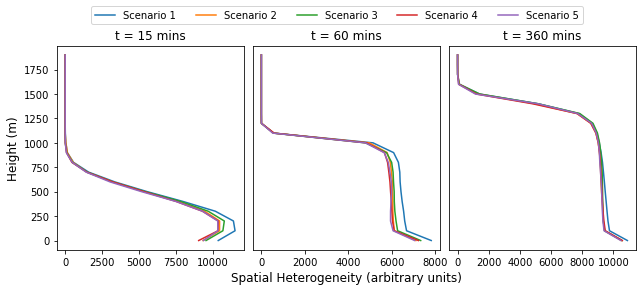

In [18]:
Plot_height_vs_SH(metric='HkNorm', k=-1)

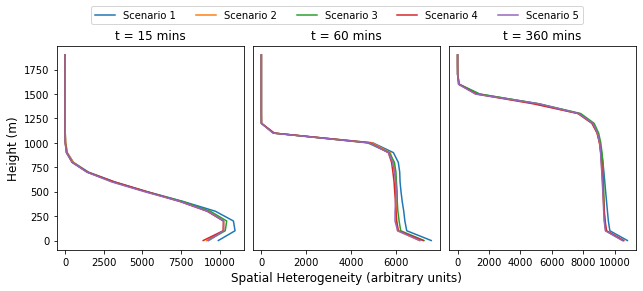

In [19]:
Plot_height_vs_SH(metric='HkNorm', k=-2)

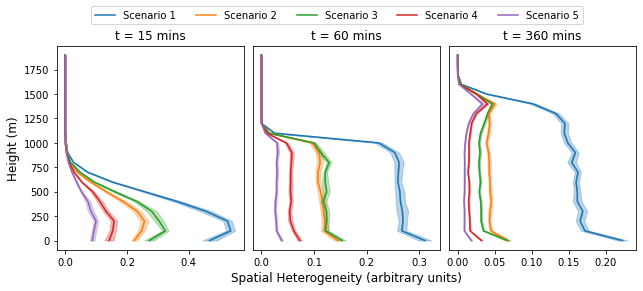

In [20]:
Plot_height_vs_SH(metric='SH')